## Alzheimer Prediction using Convolutional Neural Network

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os


### Data Preprocessing

In [25]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Datasets/Alzheimer_dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6407 files [00:13, 459.36 files/s]


In [26]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5124 files belonging to 4 classes.
Found 644 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


### Data Visualization

In [27]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


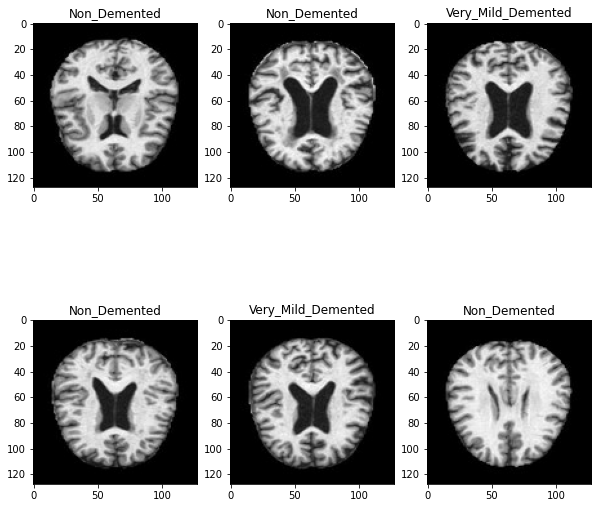

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

<function matplotlib.pyplot.show(*args, **kw)>

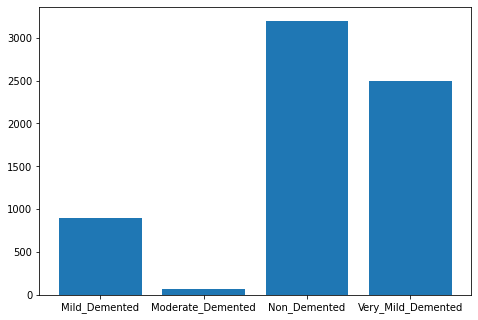

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2500]
ax.bar(class_names,size)
plt.show

### Creating Custom Model

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(32,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)       

### Training

In [33]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=32, verbose=1)

Epoch 1/50
81/81 [==============================] - 5s 54ms/step - loss: 1.0787 - accuracy: 0.4899 - val_loss: 1.0381 - val_accuracy: 0.5759
Epoch 2/50
81/81 [==============================] - 4s 41ms/step - loss: 0.9360 - accuracy: 0.5623 - val_loss: 0.9280 - val_accuracy: 0.5587
Epoch 3/50
81/81 [==============================] - 5s 63ms/step - loss: 0.8698 - accuracy: 0.5878 - val_loss: 0.8535 - val_accuracy: 0.6244
Epoch 4/50
81/81 [==============================] - 5s 59ms/step - loss: 0.7650 - accuracy: 0.6600 - val_loss: 0.8169 - val_accuracy: 0.6526
Epoch 5/50
81/81 [==============================] - 5s 60ms/step - loss: 0.6870 - accuracy: 0.7086 - val_loss: 0.6335 - val_accuracy: 0.7355
Epoch 6/50
81/81 [==============================] - 4s 49ms/step - loss: 0.5764 - accuracy: 0.7568 - val_loss: 0.4915 - val_accuracy: 0.7966
Epoch 7/50
81/81 [==============================] - 3s 36ms/step - loss: 0.4607 - accuracy: 0.8076 - val_loss: 0.4167 - val_accuracy: 0.8357
Epoch 8/50
81

### Plots

In [34]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

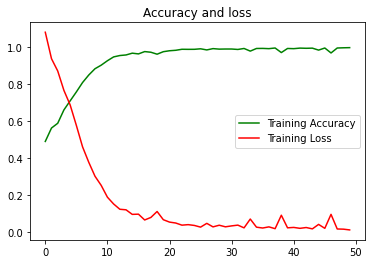

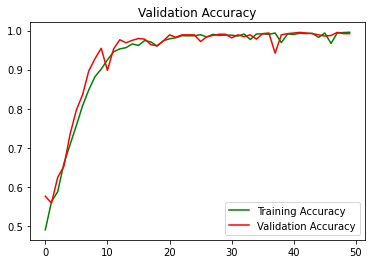

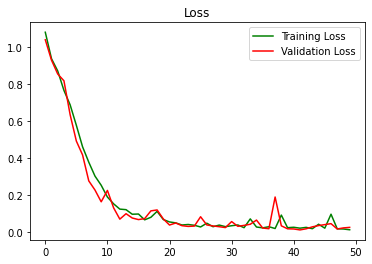

<Figure size 432x288 with 0 Axes>

In [35]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Training Accuracy')
plt.plot(epochs, get_los, 'r', label='Training Loss')
plt.title('Accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

### Validation

In [36]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.0151 - accuracy: 0.9922


### Results

1/1 [==============================] - 0s 15ms/step


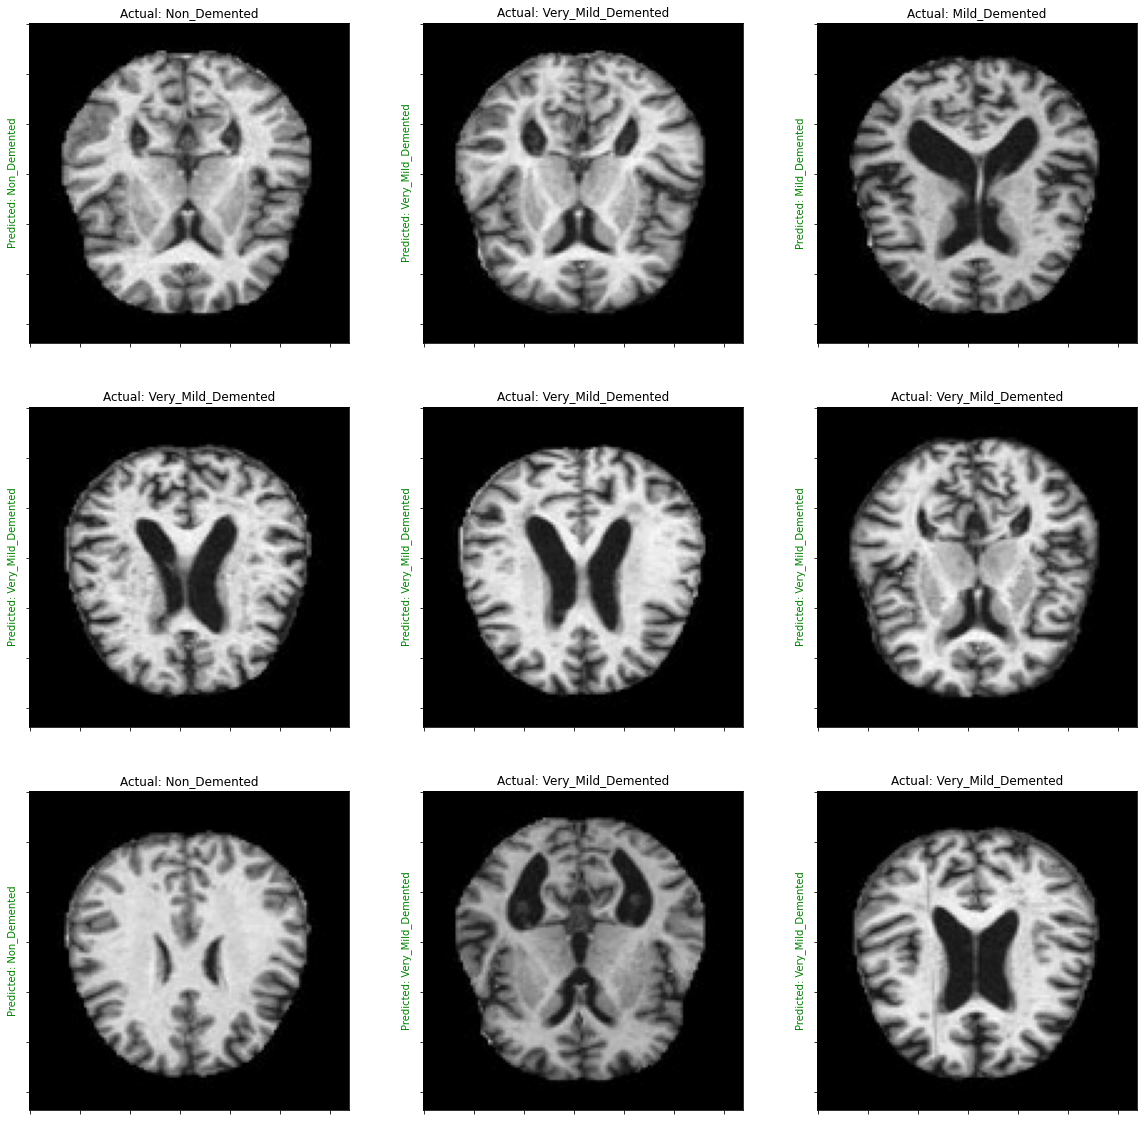

In [37]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])